<a href="https://colab.research.google.com/github/carlogattuso/Indoor_Positioning_RTT_GPR/blob/master/ap_obs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [821]:
################ Library imports ################
import numpy as np
import math as math
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import scipy.linalg
import seaborn as sns
import time
import glob
import pandas as pd

import itertools

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel, WhiteKernel

from sklearn.metrics import mean_squared_error, mean_absolute_error
 
from scipy.optimize import curve_fit

from IPython.display import display, Markdown, clear_output
import ipywidgets as widgets

In [822]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


#Utils

In [823]:
def get_location(arr, loc):
  return np.where((arr[:,0] == loc[0])&(arr[:,1] == loc[1]))[0][0]

#Dataset Reading

In [824]:
"""
File reading
"""
training = pd.read_csv('/content/drive/MyDrive/GPR/data/Meas_Sala_Actos/SalaActos_New_Large_Todos.csv', sep = ",", index_col=False, encoding='latin-1')
validation = pd.read_csv('/content/drive/MyDrive/GPR/data/Meas_Sala_Actos/SalaActos_New_Todos.csv', sep = ",", index_col=False, encoding='latin-1')
df = pd.concat([training, validation])
df = df.replace(to_replace = -100, value = np.nan)
df.head()

,batch,x,y,z,brand,model,angle,sampleNumber,30:23:03:87:17:80#1,30:23:03:87:17:81#1,30:23:03:87:17:82#1,30:23:03:87:17:98#1,30:23:03:87:17:99#1,30:23:03:87:17:9a#1,30:23:03:87:19:6c#1,30:23:03:87:19:6d#1,30:23:03:87:19:6e#1,36:23:03:87:17:80#1,36:23:03:87:17:98#1,36:23:03:87:19:6c#1,58:cb:52:d7:b4:d9#1,58:cb:52:d7:b5:31#1,58:cb:52:d7:b5:5d#1,58:cb:52:d7:bb:61#1,c4:41:1e:fa:08:88#1,c4:41:1e:fa:08:89#1,c4:41:1e:fa:08:8a#1,ca:41:1e:fa:08:88#1
0,03c6987c93bc9a98235fa5af2ccd5bb7,0.0,8.0,0.0,google,Pixel 3a,0.0,11,16.020,2.979,2.904,23.520,9.641,8.920,36.523,20.278,17.767,NaN,NaN,NaN,17.233,7.286,-0.570,16.989,24.326,6.644,5.204,NaN
1,03c6987c93bc9a98235fa5af2ccd5bb7,0.0,8.0,0.0,google,Pixel 3a,0.0,12,17.257,2.694,2.728,23.344,9.804,8.803,35.107,20.276,17.865,NaN,NaN,NaN,17.229,7.301,-0.588,17.026,24.223,6.626,5.145,NaN
2,03c6987c93bc9a98235fa5af2ccd5bb7,0.0,8.0,0.0,google,Pixel 3a,0.0,13,16.488,2.857,2.650,23.398,9.729,8.607,35.382,20.362,17.806,NaN,NaN,NaN,17.423,7.220,-0.551,16.989,23.866,6.566,5.145,NaN
3,03c6987c93bc9a98235fa5af2ccd5bb7,0.0,8.0,0.0,google,Pixel 3a,0.0,14,14.445,2.651,2.846,23.041,9.854,8.842,35.694,20.395,17.767,NaN,NaN,NaN,17.342,7.223,-0.513,17.167,23.623,6.526,5.072,NaN
4,03c6987c93bc9a98235fa5af2ccd5bb7,0.0,8.0,0.0,google,Pixel 3a,0.0,15,12.882,2.970,2.982,23.970,9.929,8.646,36.157,20.367,17.982,NaN,NaN,NaN,17.583,6.969,-0.321,16.914,23.970,6.644,5.189,24.57


#Radio-map definition

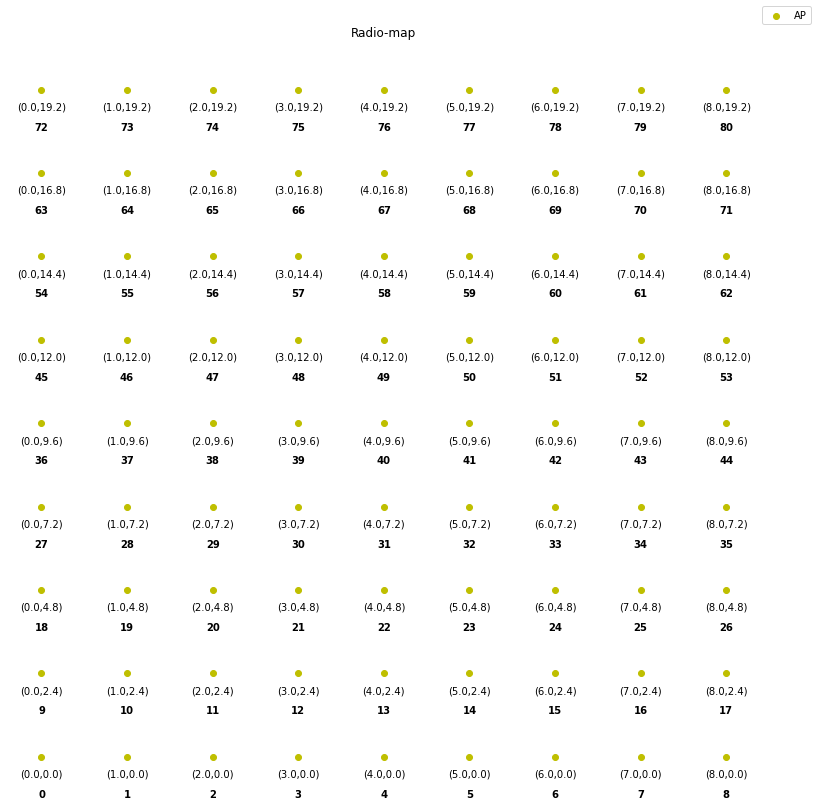

In [825]:
#@markdown ##Size
width =  8#@param {type:"number"}
height = 19.2 #@param {type:"number"}

#@markdown ##Granularity (meters)
granularity_x =  1#@param {type:"number"}
granularity_y =  2.3#@param {type:"number"}

points_x = int(width/granularity_x +1)
points_y = int(height/granularity_y +1)

n_points = points_x * points_y

"""
Locations grid
"""
locations = np.array(np.meshgrid(np.linspace(0, height, points_y).round(3), np.linspace(0, width, points_x).round(3))).T.reshape(-1,2)
locations[:, [1, 0]] = locations[:, [0, 1]]

"""
Plot coordinates
"""
coordinates = np.array(np.meshgrid(np.linspace(0, points_y - 1, points_y), np.linspace(0, points_x - 1, points_x))).T.reshape(-1,2)
coordinates[:, [1, 0]] = coordinates[:, [0, 1]]

plt.figure(figsize=(points_x*1.5, points_y*1.5))

plt.scatter(coordinates[:,0], coordinates[:,1], c='y')

plt.legend(labels=['AP','VRP'],loc="upper right",borderaxespad=-5)
plt.title('Radio-map',pad=20)
plt.axis('off')

for x,y,z in zip(coordinates[:,0],coordinates[:,1], np.linspace(0, n_points - 1, n_points).astype(int)):
    label = f"({locations[z,0]},{locations[z,1]})"

    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,-20), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center

    label = f"{z}"

    plt.annotate(label, # this is the text
                  (x,y), # this is the point to label
                  textcoords="offset points", # how to position the text
                  xytext=(0,-40), # distance from text to points (x,y)
                  ha='center',
                  weight='bold') # horizontal alignment can be left, right or center

#AP definition

##AP class

### Handles the required parameters for each AP

####Parameters:

*   name (string)
*   x (number)
*   y (number)
*   point (number)


In [826]:
class AP:
    '''
 
    '''
    def __init__(self, _name, _x, _y, _mac):
        self.name = _name
        self.x = _x
        self.y = _y
        self.mac = _mac
        self.point = get_location(locations, [_x, _y])

##Create APs

In [827]:
ap_list = []

ap_list.append(AP('Google Blanco', 0, 19.2, '58:cb:52:d7:b4:d9#1'))

ap_list.append(AP('Google Azul', 0, 0, '58:cb:52:d7:b5:31#1'))

ap_list.append(AP('Linksys 1', 4, 0, '30:23:03:87:17:80#1'))

ap_list.append(AP('Google Verde', 8, 0, '58:cb:52:d7:b5:5d#1'))

ap_list.append(AP('Linksys 2', 0, 9.6, '30:23:03:87:17:98#1'))

ap_list.append(AP('Google Rojo', 8.0, 19.2, '58:cb:52:d7:bb:61#1'))

ap_list.append(AP('Linksys 3', 4, 19.2, '30:23:03:87:19:6c#1'))

ap_list.append(AP('Linksys 4', 8, 9.6, 'c4:41:1e:fa:08:88#1'))

##Sort APs by location

In [828]:
ap_labels = {}
ap_indexes = {}
ap_mac = []

"""
Sorting AP list
"""
ap_list.sort(key=lambda x: x.point)

print("List of Access Points: \n\n")
points = []
for i in range(len(ap_list)):
  points.append(ap_list[i].point)
  ap_labels[i]=ap_list[i].name
  ap_indexes[str(ap_list[i].name)]=i
  ap_mac.append(ap_list[i].mac)
  print(ap_list[i].name,'-->',' x: ',ap_list[i].x,' y: ', 
        ap_list[i].y, ' point: ', ap_list[i].point, '\n')

print('\nAP Points: ', points, '\n\n')
print("MAC Address List: \n\n")
print(ap_mac)

List of Access Points: 


Google Azul -->  x:  0  y:  0  point:  0 

Linksys 1 -->  x:  4  y:  0  point:  4 

Google Verde -->  x:  8  y:  0  point:  8 

Linksys 2 -->  x:  0  y:  9.6  point:  36 

Linksys 4 -->  x:  8  y:  9.6  point:  44 

Google Blanco -->  x:  0  y:  19.2  point:  72 

Linksys 3 -->  x:  4  y:  19.2  point:  76 

Google Rojo -->  x:  8.0  y:  19.2  point:  80 


AP Points:  [0, 4, 8, 36, 44, 72, 76, 80] 


MAC Address List: 


['58:cb:52:d7:b5:31#1', '30:23:03:87:17:80#1', '58:cb:52:d7:b5:5d#1', '30:23:03:87:17:98#1', 'c4:41:1e:fa:08:88#1', '58:cb:52:d7:b4:d9#1', '30:23:03:87:19:6c#1', '58:cb:52:d7:bb:61#1']


#Final Scenario 

In [829]:
"""
AP locations
"""
L_ap = locations[points,:]

"""
VRP locations
"""
L_vrp = np.delete(locations, points, 0)

n_ap = len(ap_list)
n_vrp = n_points - n_ap

"""
Locations split
"""
coordinates_ap = coordinates[points,:]
coordinates_vrp = np.delete(coordinates, points, 0)

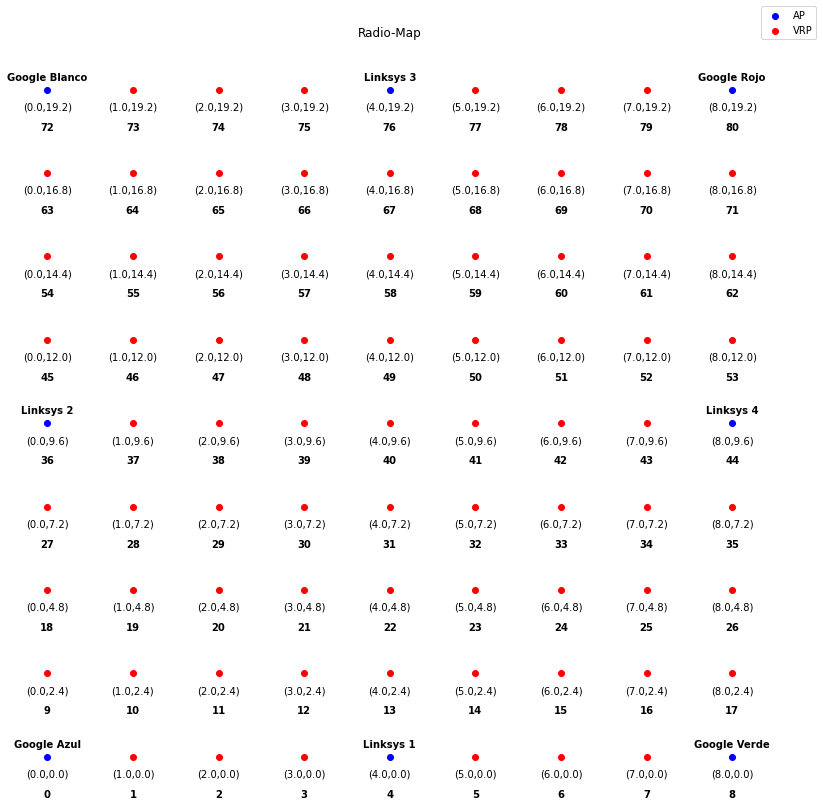

In [830]:
#@title ##Scenario Plot
plt.figure(figsize=(points_x*1.5, points_y*1.5))

plt.scatter(coordinates_ap[:,0], coordinates_ap[:,1], c='b')
plt.scatter(coordinates_vrp[:,0], coordinates_vrp[:,1], c='r')

plt.legend(labels=['AP','VRP'],loc="upper right",borderaxespad=-5)
plt.title('Radio-Map',pad=20)
plt.axis('off')

for x,y,z in zip(coordinates[:,0],coordinates[:,1], np.linspace(0, n_points - 1, n_points).astype(int)):
    label = f"({locations[z,0]},{locations[z,1]})"

    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,-20), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center

    label = f"{z}"

    plt.annotate(label, # this is the text
                  (x,y), # this is the point to label
                  textcoords="offset points", # how to position the text
                  xytext=(0,-40), # distance from text to points (x,y)
                  ha='center',
                  weight='bold') # horizontal alignment can be left, right or center

for x,y,z in zip(coordinates_ap[:,0],coordinates_ap[:,1], np.linspace(0, n_ap - 1, n_ap).astype(int)):
    label = f"{ap_labels[z]}"

    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center', # horizontal alignment can be left, right or center
                 weight='bold')

#RTT Observations among APs

In [831]:
def split_df(row, index):
  '''
  Special distances correction
  '''
  if row[0] == 8.0 and row[1] == 19.2:
    row[0] = 8.1

  aux = df.loc[(df['y'] == row[0]) & (df['x'] == row[1])]
  aux = aux[ap_mac].values
  aux = aux.T
  
  return aux

In [832]:
"""
Dataset split
    - ap_obs --> RTT observations between APs

We are getting RTT observations from dataset, splitting AP and VRP samples

ap_obs(target AP, reference AP, sample)
"""

ap_obs = np.array([split_df(L_ap[i], i) for (i) in np.linspace(0, n_ap - 1, n_ap).astype(int)]).round(3)
n_samples = ap_obs.shape[2]

In [833]:
'''
Simulating nan values only for test
'''
ap_obs[0,1,8] = math.nan
ap_obs[2,1,9] = math.nan
ap_obs[2,3,56] = math.nan
ap_obs[1,0,9] = math.nan

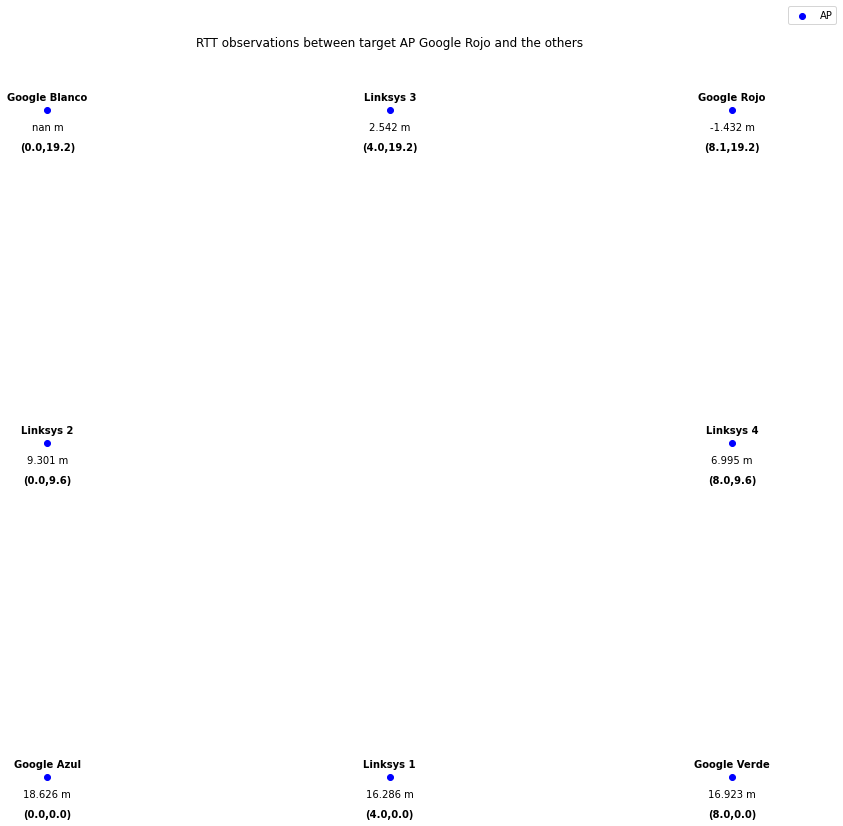

In [834]:
#@title ##Observations plot
ap_selected = "Google Rojo"  #@param ['Google Blanco', 'Linksys 1', 'Google Azul', 'Linksys 2', 'Google Rojo', 'Linksys 3', 'Google Verde']
sample = 12 #@param {type:"slider", min:0, max:100, step:1}

try:
  ap_indexes[ap_selected]
except:
  ap_selected = ap_labels[0]
  
plt.figure(figsize=(points_x*1.5, points_y*1.5))

plt.scatter(coordinates_ap[:,0], coordinates_ap[:,1], c='b')

plt.legend(labels=['AP'],loc="upper right",borderaxespad=-7)
plt.title('RTT observations between target AP '+ap_selected+' and the others',pad=30)
plt.axis('off')

for x,y,z in zip(coordinates_ap[:,0], coordinates_ap[:,1], ap_obs[:,int(ap_indexes[ap_selected]),sample]):
    label = f"{z.round(3)} m"

    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,-20), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center

for x,y,z in zip(coordinates_ap[:,0],coordinates_ap[:,1], np.linspace(0, n_ap - 1, n_ap).astype(int)):

    label = f"{ap_labels[z]}"

    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center', # horizontal alignment can be left, right or center
                 weight='bold')

for x,y,z in zip(coordinates_ap[:,0],coordinates_ap[:,1], np.linspace(0, n_ap - 1, n_ap).astype(int)):
    label = f"({L_ap[z,0]},{L_ap[z,1]})"

    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,-40), # distance from text to points (x,y)
                 ha='center',
                 weight='bold') # horizontal alignment can be left, right or center

#Polynomial Surface Fitting

In [835]:
"""
Polynomial Surface model fitting
    
    loc --> X,Y tuple array of AP locations
    d --> AP RTT distance observations
    order --> Polinomial order
"""
def surface_fit(loc, d, order=1):
    '''
    Clear nan values
    '''
    idx = np.argwhere(np.isnan(d)).T[0]
    loc = np.delete(loc, idx, 0)
    d = np.delete(d, idx)

    '''
    Computing polynomial surface coefficients
    '''
    if order == 1:
        A = np.c_[loc[:,0], loc[:,1], np.ones(loc.shape[0])]
        C,_,_,_ = scipy.linalg.lstsq(A, d)
    else:
        A = np.c_[np.ones(loc.shape[0]), loc[:,:2], np.prod(loc[:,:2], axis=1), loc[:,:2]**2]
        C,_,_,_ = scipy.linalg.lstsq(A, d)
    return C

In [836]:
"""
Mean RTT distance estimation
    
    x --> AP's x locations
    y --> AP's y locations
    C --> Model coefficients
"""
def sample_distance(x, y, C):
    XX = x.flatten()
    YY = y.flatten()
    
    if C.shape[0] == 3:
        fit = np.dot(np.c_[XX, YY, np.ones(XX.shape)], C).reshape(x.shape)
    else:
        fit = np.dot(np.c_[np.ones(XX.shape), XX, YY, XX*YY, XX**2, YY**2], C).reshape(x.shape)
    return fit

In [837]:
"""
Surface fitting models
"""

"""
Plot domain
"""
X,Y = np.meshgrid(np.linspace(0, width, points_x).round(3), np.linspace(0, height, points_y).round(3))

"""
Models fitting and surface estimation
"""
models_1 = np.array([np.array([surface_fit(L_ap, ap_obs[:,j,i]) 
                      for (i) in np.linspace(0, n_samples - 1, n_samples).astype(int)]) 
                      for (j) in np.linspace(0, n_ap - 1, n_ap).astype(int)]) 

models_2 = np.array([np.array([surface_fit(L_ap, ap_obs[:,j,i],2) 
                      for (i) in np.linspace(0, n_samples - 1, n_samples).astype(int)]) 
                      for (j) in np.linspace(0, n_ap - 1, n_ap).astype(int)])

Z_1 = np.array([np.array([sample_distance(X, Y, models_1[j,i,:]) 
                      for (i) in np.linspace(0, n_samples - 1, n_samples).astype(int)]) 
                      for (j) in np.linspace(0, n_ap - 1, n_ap).astype(int)])

Z_2 = np.array([np.array([sample_distance(X, Y, models_2[j,i,:]) 
                      for (i) in np.linspace(0, n_samples - 1, n_samples).astype(int)]) 
                      for (j) in np.linspace(0, n_ap - 1, n_ap).astype(int)])

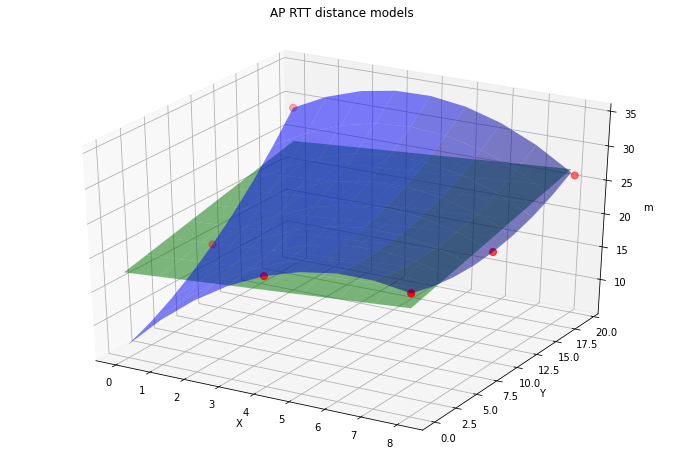

In [838]:
#@title ##Surface Fitting Models Plot
ap_selected = "Linksys 2"  #@param ['Google Blanco', 'Linksys 1', 'Google Azul', 'Linksys 2', 'Google Rojo', 'Linksys 3', 'Google Verde']
sample = 8 #@param {type:"slider", min:0, max:100, step:1}

try:
  ap_indexes[ap_selected]
except:
  ap_selected = ap_labels[0]

fig = plt.figure(figsize=(12,8))

ax = fig.gca(projection='3d')

l1 = ax.plot_surface(X, Y, Z_1[int(ap_indexes[ap_selected]),sample], rstride=1, cstride=1, alpha=0.5, label='linear', color='g')
l2 = ax.plot_surface(X, Y, Z_2[int(ap_indexes[ap_selected]),sample], rstride=1, cstride=1, alpha=0.5, label='quadratic', color='b')

ax.scatter(L_ap[:,0], L_ap[:,1], ap_obs[:,int(ap_indexes[ap_selected]),sample], c='r', s=50)

plt.xlabel('X')
plt.ylabel('Y')
ax.set_zlabel('m')
ax.axis('auto')

plt.title('AP RTT distance models', pad=40)
plt.show()

##Mean RTT Distance vectors

In [839]:
"""
Mean RTT distance values at VRPs
    _1 --> Order 1 surface fit
    _2 --> Order 2 surface fit
"""

fit_1 = np.reshape(Z_1, (n_ap, n_samples, n_points, 1))
fit_2 = np.reshape(Z_2, (n_ap, n_samples, n_points, 1))

"""
Mean RTT observations between target AP and the rest
"""
m_ap_1 = np.array([fit_1[:, i, points, :] for (i) in np.linspace(0, n_samples - 1, n_samples).astype(int)])
m_ap_2 = np.array([fit_2[:, i, points, :] for (i) in np.linspace(0, n_samples - 1, n_samples).astype(int)])

"""
Reference points vector
"""
vrp_pts = np.delete(np.linspace(0, n_points - 1, n_points).astype(int), points, 0)

"""
Mean RTT observations between target AP and VRPs
"""
m_vrp_1 = np.array([fit_1[:, i, vrp_pts, :] for (i) in np.linspace(0, n_samples - 1, n_samples).astype(int)])
m_vrp_2 = np.array([fit_2[:, i, vrp_pts, :] for (i) in np.linspace(0, n_samples - 1, n_samples).astype(int)])

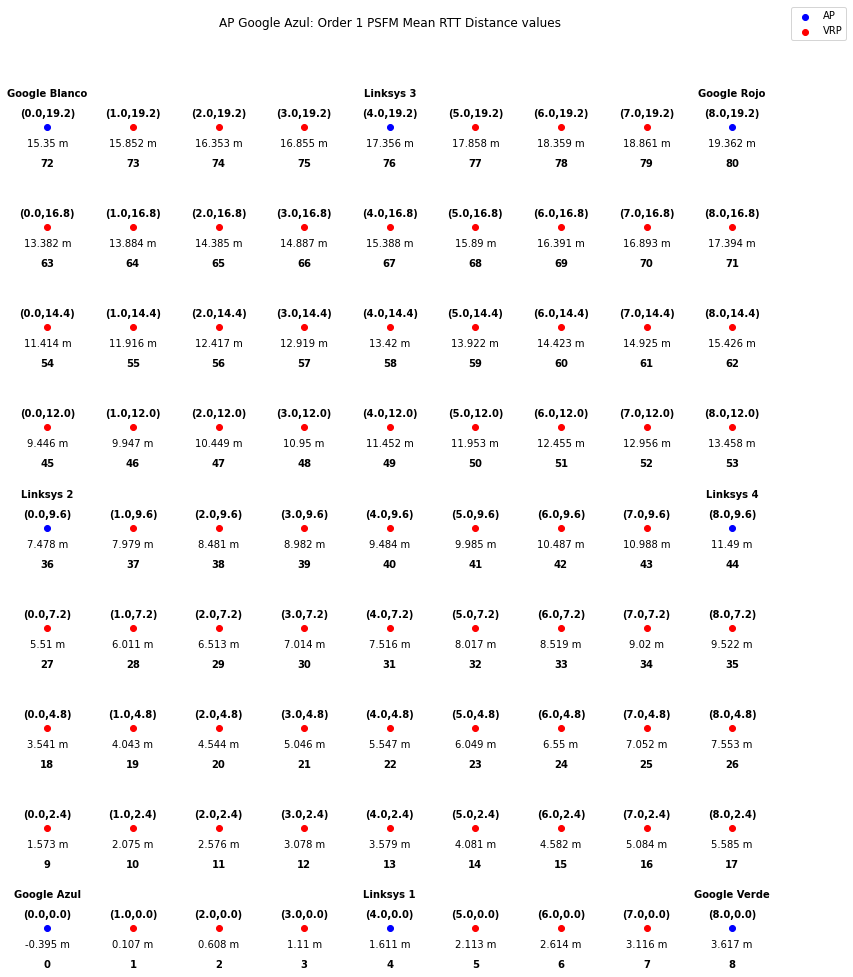

In [840]:
#@title ##Order 1 PSFM Mean RTT Distance Plot
ap_selected = "Google Azul"  #@param ['Google Blanco', 'Linksys 1', 'Google Azul', 'Linksys 2', 'Google Rojo', 'Linksys 3', 'Google Verde']
sample = 8 #@param {type:"slider", min:0, max:100, step:1}

try:
  ap_indexes[ap_selected]
except:
  ap_selected = ap_labels[0]

plt.figure(figsize=(points_x*1.5, points_y*1.8))

plt.scatter(coordinates_ap[:,0], coordinates_ap[:,1], c='b')
plt.scatter(coordinates_vrp[:,0], coordinates_vrp[:,1], c='r')

plt.legend(labels=['AP','VRP'],loc="upper right",borderaxespad=-8)
plt.title('AP '+ap_selected+': Order 1 PSFM Mean RTT Distance values',pad=60)
plt.axis('off')

for x,y,z in zip(coordinates[:,0], coordinates[:,1], np.linspace(0, n_points - 1, n_points).astype(int)):
    label = f"{fit_1[int(ap_indexes[ap_selected]),sample,z][0].round(3)} m"

    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,-20), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center

for x,y,z in zip(coordinates[:,0],coordinates[:,1], np.linspace(0, n_points - 1, n_points).astype(int)):
    label = f"({locations[z,0]},{locations[z,1]})"

    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center',
                 weight='bold') # horizontal alignment can be left, right or center

    label = f"{z}"

    plt.annotate(label, # this is the text
                  (x,y), # this is the point to label
                  textcoords="offset points", # how to position the text
                  xytext=(0,-40), # distance from text to points (x,y)
                  ha='center',
                  weight='bold') # horizontal alignment can be left, right or center

for x,y,z in zip(coordinates_ap[:,0],coordinates_ap[:,1], np.linspace(0, n_ap - 1, n_ap).astype(int)):

    label = f"{ap_labels[z]}"

    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,30), # distance from text to points (x,y)
                 ha='center', # horizontal alignment can be left, right or center
                 weight='bold')

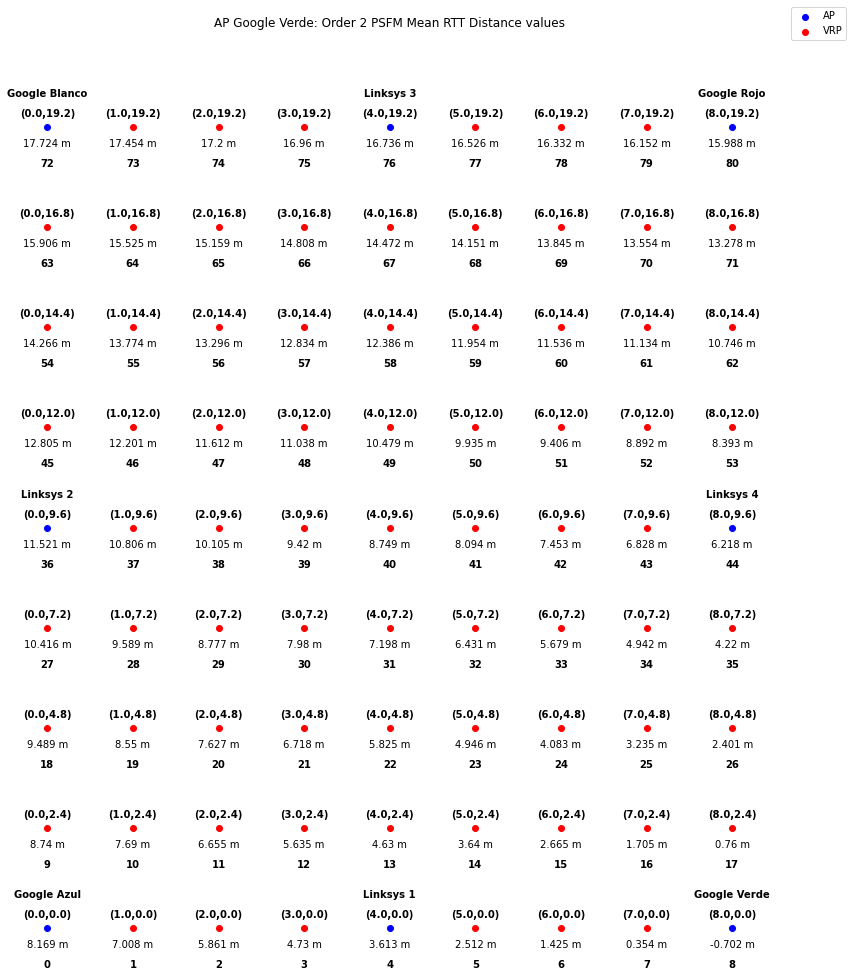

In [841]:
#@title ##Order 2 PSFM Mean RTT Distance Plot
ap_selected = "Google Verde"  #@param ['Google Blanco', 'Linksys 1', 'Google Azul', 'Linksys 2', 'Google Rojo', 'Linksys 3', 'Google Verde']
sample = 8 #@param {type:"slider", min:0, max:100, step:1}

try:
  ap_indexes[ap_selected]
except:
  ap_selected = ap_labels[0]

plt.figure(figsize=(points_x*1.5, points_y*1.8))

plt.scatter(coordinates_ap[:,0], coordinates_ap[:,1], c='b')
plt.scatter(coordinates_vrp[:,0], coordinates_vrp[:,1], c='r')

plt.legend(labels=['AP','VRP'],loc="upper right",borderaxespad=-8)
plt.title('AP '+ap_selected+': Order 2 PSFM Mean RTT Distance values',pad=60)
plt.axis('off')

for x,y,z in zip(coordinates[:,0], coordinates[:,1], np.linspace(0, n_points - 1, n_points).astype(int)):
    label = f"{fit_2[int(ap_indexes[ap_selected]),sample,z][0].round(3)} m"

    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,-20), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center

for x,y,z in zip(coordinates[:,0],coordinates[:,1], np.linspace(0, n_points - 1, n_points).astype(int)):
    label = f"({locations[z,0]},{locations[z,1]})"

    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center',
                 weight='bold') # horizontal alignment can be left, right or center

    label = f"{z}"

    plt.annotate(label, # this is the text
                  (x,y), # this is the point to label
                  textcoords="offset points", # how to position the text
                  xytext=(0,-40), # distance from text to points (x,y)
                  ha='center',
                  weight='bold') # horizontal alignment can be left, right or center

for x,y,z in zip(coordinates_ap[:,0],coordinates_ap[:,1], np.linspace(0, n_ap - 1, n_ap).astype(int)):

    label = f"{ap_labels[z]}"

    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,30), # distance from text to points (x,y)
                 ha='center', # horizontal alignment can be left, right or center
                 weight='bold')

#Gaussian Process Regression

##Kernel definition

In [842]:
"""
Gaussian Process Kernel definition

Kernel parameters:
    - L --> Length Scale
    - sigma_f --> Constant Kernel Amplitude
"""

def kernel_function(x, y, sigma_f=1, l=1):

    """ Squared Exponential kernel function """
    kernel = sigma_f * np.exp(- (np.linalg.norm(x - y)**2) / (2 * l**2))
    return kernel

##Hyperparameter optimization

In [843]:
"""
Hyperparameter optimization of sigma_f and length-scale

    loc --> AP locations
    mean --> RTT distance observations between APs
"""
def gp_fit(loc, mean):
    '''
    Clear nan values
    '''
    idx = np.argwhere(np.isnan(mean)).T[0]
    loc = np.delete(loc, idx, 0)
    mean = np.delete(mean, idx)

    gp.fit(loc, mean)

    l = gp.kernel_.get_params().get('k2__length_scale')
    sigma_f = gp.kernel_.get_params().get('k1__constant_value')
    return l, sigma_f

In [844]:
"""
Gaussian Process Fit using scikit-learn GPR
"""
sigma_n = 0.0

kernel = ConstantKernel(constant_value=100.0,constant_value_bounds=(1e-3, 1e3)) \
            * RBF(length_scale=10.0, length_scale_bounds=(1e-3, 1e3))

gp = GaussianProcessRegressor(kernel=kernel, alpha=sigma_n**2, n_restarts_optimizer=10)

hyper_params = np.array([np.array([gp_fit(L_ap, ap_obs[:,j,i]) 
                      for (i) in np.linspace(0, n_samples - 1, n_samples).astype(int)]) 
                      for (j) in np.linspace(0, n_ap - 1, n_ap).astype(int)])

##Covariance matrices

 

###Covariance matrix computing

In [845]:
def compute_k_matrix(loc, obs, sigma_f=1, l=1):
    '''
    Clear nan values
    '''
    idx = np.argwhere(np.isnan(obs)).T[0]
    loc = np.delete(loc, idx, 0)

    """
    Compute components of the covariance matrix of the joint distribution.
    
    We follow the notation:
        - K = K(L, L)
    """
    
    K = [kernel_function(i, j, sigma_f=sigma_f, l=l) for (i, j) in itertools.product(loc, loc)]
    K = np.array(K).reshape(loc.shape[0], loc.shape[0])

    return K

In [846]:
def compute_k_star_matrix(loc, ref, obs, sigma_f=1, l=1):
    '''
    Clear nan values
    '''
    idx = np.argwhere(np.isnan(obs)).T[0]
    loc = np.delete(loc, idx, 0)

    """
    Compute components of the covariance matrix of the joint distribution.
    
    We follow the notation:
        - K_star = K(L^*, L)
    """
    K_star = [kernel_function(i, j, sigma_f=sigma_f, l=l) for (i, j) in itertools.product(ref, loc)]
    K_star = np.array(K_star).reshape(ref.shape[0], loc.shape[0])

    return K_star

In [847]:
def compute_k_star2_matrix(ref, sigma_f=1, l=1):
    """
    Compute components of the covariance matrix of the joint distribution.
    
    We follow the notation:
        - K_star2 = K(L^*, L^*)
    """

    K_star2 = [kernel_function(i, j, sigma_f=sigma_f, l=l) for (i, j) in itertools.product(ref, ref)]
    K_star2 = np.array(K_star2).reshape(ref.shape[0], ref.shape[0])
    
    return K_star2

In [848]:
"""
Covariance matrices and regressor objects computing:

    - Covariance matrices: K, K_star, K_star2
"""

k_array = np.empty(n_samples, dtype=object)
for (i) in np.linspace(0, n_samples - 1, n_samples).astype(int):
  aux = np.array([compute_k_matrix(L_ap, 
                                   ap_obs[:,j,i],
                                   sigma_f=hyper_params[j,i][1], 
                                   l=hyper_params[j,i][0]) 
                  for (j) in np.linspace(0, n_ap - 1, n_ap).astype(int)], dtype=object)
  k_array[i] = aux

k_star2_array = np.empty(n_samples, dtype=object)
for (i) in np.linspace(0, n_samples - 1, n_samples).astype(int):
  aux = np.array([compute_k_star2_matrix(L_vrp,
                                         sigma_f=hyper_params[j,i][1], 
                                        l=hyper_params[j,i][0]) 
                  for (j) in np.linspace(0, n_ap - 1, n_ap).astype(int)], dtype=object)
  k_star2_array[i] = aux

k_star_array = np.empty(n_samples, dtype=object)
for (i) in np.linspace(0, n_samples - 1, n_samples).astype(int):
  aux_array = np.empty(n_ap, dtype=object)
  for (j) in np.linspace(0, n_ap - 1, n_ap).astype(int):
    aux = compute_k_star_matrix(L_ap,
                                L_vrp,
                                ap_obs[:,j,i],
                                sigma_f=hyper_params[j,i][1], 
                                l=hyper_params[j,i][0])
    aux_array[j] = aux
  k_star_array[i] = aux_array

In [849]:
#@title ###Multivariate Gaussian Process Dimension Check
ap_selected = "Google Blanco"  #@param ['Google Blanco', 'Linksys 1', 'Google Azul', 'Linksys 2', 'Google Rojo', 'Linksys 3', 'Google Verde']
sample = 8 #@param {type:"slider", min:0, max:100, step:1}

try:
  ap_indexes[ap_selected]
except:
  ap_selected = ap_labels[0]
  
"""
Multivariate Joint Distribution Check: G matrix
"""
k_array_len = k_array[sample][int(ap_indexes[ap_selected])].shape[0]
k_star2_array_len = k_star2_array[sample][int(ap_indexes[ap_selected])].shape[0]

a = np.concatenate((k_array[sample][int(ap_indexes[ap_selected])] 
                    + (sigma_n**2)*np.eye(k_array_len), 
                    k_star_array[sample][int(ap_indexes[ap_selected])]), axis=0)
print(a.shape)
b = np.concatenate((k_star_array[sample][int(ap_indexes[ap_selected])].T, k_star2_array[sample][int(ap_indexes[ap_selected])]), axis=0)
print(b.shape)
G = np.concatenate((a, b), axis=1)
print(G.shape)
G.shape == (k_array_len + k_star2_array_len, k_array_len + k_star2_array_len)

(81, 8)
(81, 73)
(81, 81)


True

###Covariance matrices plot


Covariance matrix: 




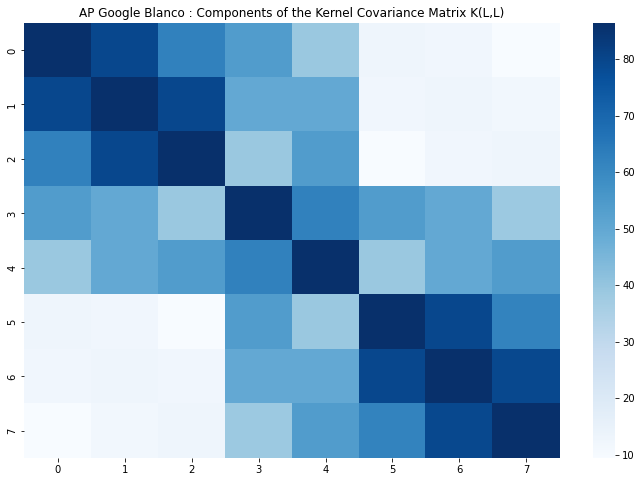

In [877]:
#@title ###K Matrix Plot
ap_selected = "Google Blanco"  #@param ['Google Blanco', 'Linksys 1', 'Google Azul', 'Linksys 2', 'Google Rojo', 'Linksys 3', 'Google Verde']
sample = 0 #@param {type:"slider", min:0, max:100, step:1}

try:
  ap_indexes[ap_selected]
except:
  ap_selected = ap_labels[0]

"""
Kernel Covariance Matrix K(L,L)
"""
fig, ax = plt.subplots(figsize=(12, 8))
sns.heatmap(data=k_array[sample][int(ap_indexes[ap_selected])].astype(np.float), cmap='Blues', ax=ax)
ax.set(title='AP '+ap_selected+' : Components of the Kernel Covariance Matrix K(L,L)')
print("\nCovariance matrix: \n\n")


Covariance matrices: 




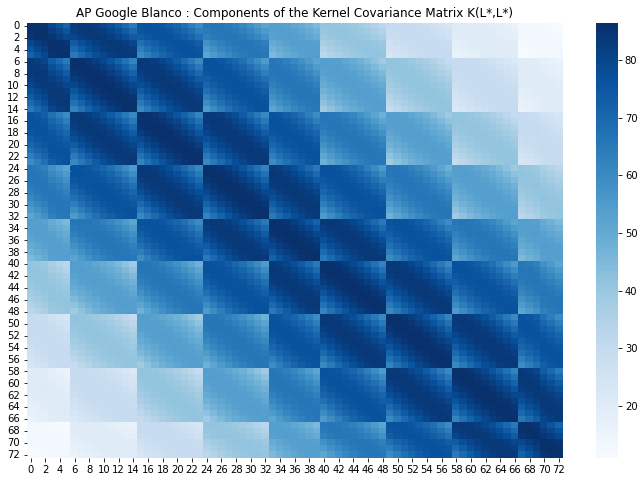

In [876]:
#@title ###K Star Squared Matrix
ap_selected = "Google Blanco"  #@param ['Google Blanco', 'Linksys 1', 'Google Azul', 'Linksys 2', 'Google Rojo', 'Linksys 3', 'Google Verde']
sample = 0 #@param {type:"slider", min:0, max:100, step:1}

try:
  ap_indexes[ap_selected]
except:
  ap_selected = ap_labels[0]

"""
Kernel Covariance Matrix K(L*,L*)
"""
fig, ax = plt.subplots(figsize=(12, 8))
sns.heatmap(data=k_star2_array[sample][int(ap_indexes[ap_selected])].astype(np.float), cmap='Blues', ax=ax)
ax.set(title='AP '+ap_selected+' : Components of the Kernel Covariance Matrix K(L*,L*)')
print("\nCovariance matrices: \n\n")


Covariance matrices: 




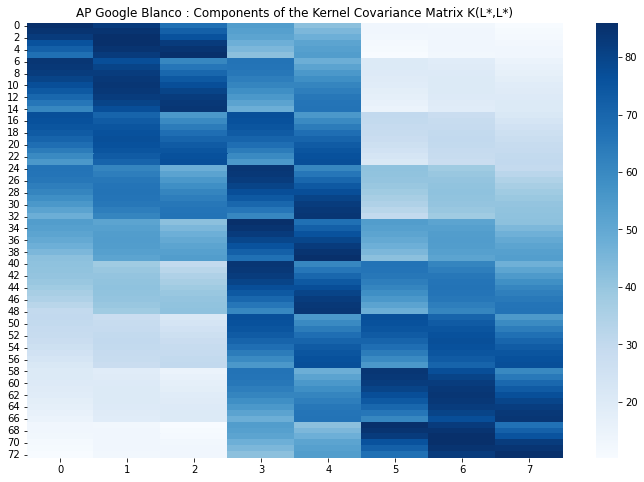

In [878]:
#@title ###K Star Matrix
ap_selected = "Google Blanco"  #@param ['Google Blanco', 'Linksys 1', 'Google Azul', 'Linksys 2', 'Google Rojo', 'Linksys 3', 'Google Verde']
sample = 0 #@param {type:"slider", min:0, max:100, step:1}

try:
  ap_indexes[ap_selected]
except:
  ap_selected = ap_labels[0]

"""
Kernel Covariance Matrix K(L*,L)
"""
fig, ax = plt.subplots(figsize=(12, 8))
sns.heatmap(data=k_star_array[sample][int(ap_indexes[ap_selected])].astype(np.float), cmap='Blues', ax=ax)
ax.set(title='AP '+ap_selected+' : Components of the Kernel Covariance Matrix K(L*,L*)')
print("\nCovariance matrices: \n\n")

#PSFM GPR Interpolation

##Interpolation Computing

In [853]:
def psfm_gpr_mean(m, m_star, d, K, K_star, sigma_n):
    '''
    Clear nan values
    '''
    idx = np.argwhere(np.isnan(d)).T[0]
    m = np.delete(m, idx)
    d = np.delete(d, idx)

    """Compute gaussian regression parameters."""
    s_bar_star = (m_star.reshape([m_star.shape[0], 1]) 
        + np.dot(K_star, np.dot(np.linalg.inv(K + (sigma_n**2)*np.eye(K.shape[0])), d.reshape([d.shape[0], 1]) - m.reshape([m.shape[0], 1]))))
    
    return s_bar_star.reshape(n_vrp)

In [854]:
def zero_mean_gpr_mean(d, K, K_star, sigma_n):
    '''
    Clear nan values
    '''
    idx = np.argwhere(np.isnan(d)).T[0]
    d = np.delete(d, idx)

    """Compute gaussian regression parameters."""
    s_bar_star = np.dot(K_star, np.dot(np.linalg.inv(K + (sigma_n**2)*np.eye(K.shape[0])), d.reshape([d.shape[0], 1])))
    
    return s_bar_star.reshape(n_vrp)

In [855]:
def zero_mean_gpr_cov(K, K_star2, K_star, sigma_n):

    """Compute gaussian regression parameters."""
    cov_s_star = K_star2 - np.dot(K_star, np.dot(np.linalg.inv(K + (sigma_n**2)*np.eye(K.shape[0])), K_star.T))
    
    return cov_s_star

In [856]:
"""
Zero-Mean Gaussian Process interpolations
"""
mean_array = np.array([np.array([zero_mean_gpr_mean(ap_obs[:,j,i], 
                                                    k_array[i][j].astype(np.float), 
                                                    k_star_array[i][j].astype(np.float), 
                                                    sigma_n).reshape(n_vrp,1)
                                for (i) in np.linspace(0, n_samples - 1, n_samples).astype(int)])
                                for (j) in np.linspace(0, n_ap - 1, n_ap).astype(int)])
                                  

var_array = np.array([np.array([np.diag(zero_mean_gpr_cov(k_array[i][j].astype(np.float), 
                                                          k_star2_array[i][j].astype(np.float), 
                                                          k_star_array[i][j].astype(np.float), 
                                                          sigma_n)).reshape(n_vrp,1)
                                  for (i) in np.linspace(0, n_samples - 1, n_samples).astype(int)])
                                  for (j) in np.linspace(0, n_ap - 1, n_ap).astype(int)])

"""
Order 1 PSFM Gaussian Process interpolations
"""
mean_psfm_array = np.array([np.array([psfm_gpr_mean(m_ap_1[i,j], 
                                                    m_vrp_1[i,j], 
                                                    ap_obs[:,j,i], 
                                                    k_array[i][j].astype(np.float), 
                                                    k_star_array[i][j].astype(np.float), 
                                                    sigma_n).reshape(n_vrp,1)
                                      for (i) in np.linspace(0, n_samples - 1, n_samples).astype(int)])
                                      for (j) in np.linspace(0, n_ap - 1, n_ap).astype(int)])

"""
Order 2 PSFM Gaussian Process interpolations
"""
mean_psfm2_array = np.array([np.array([psfm_gpr_mean(m_ap_2[i,j], 
                                                    m_vrp_2[i,j], 
                                                    ap_obs[:,j,i], 
                                                    k_array[i][j].astype(np.float), 
                                                    k_star_array[i][j].astype(np.float), 
                                                    sigma_n).reshape(n_vrp,1)
                                      for (i) in np.linspace(0, n_samples - 1, n_samples).astype(int)])
                                      for (j) in np.linspace(0, n_ap - 1, n_ap).astype(int)])

##Interpolation Plots

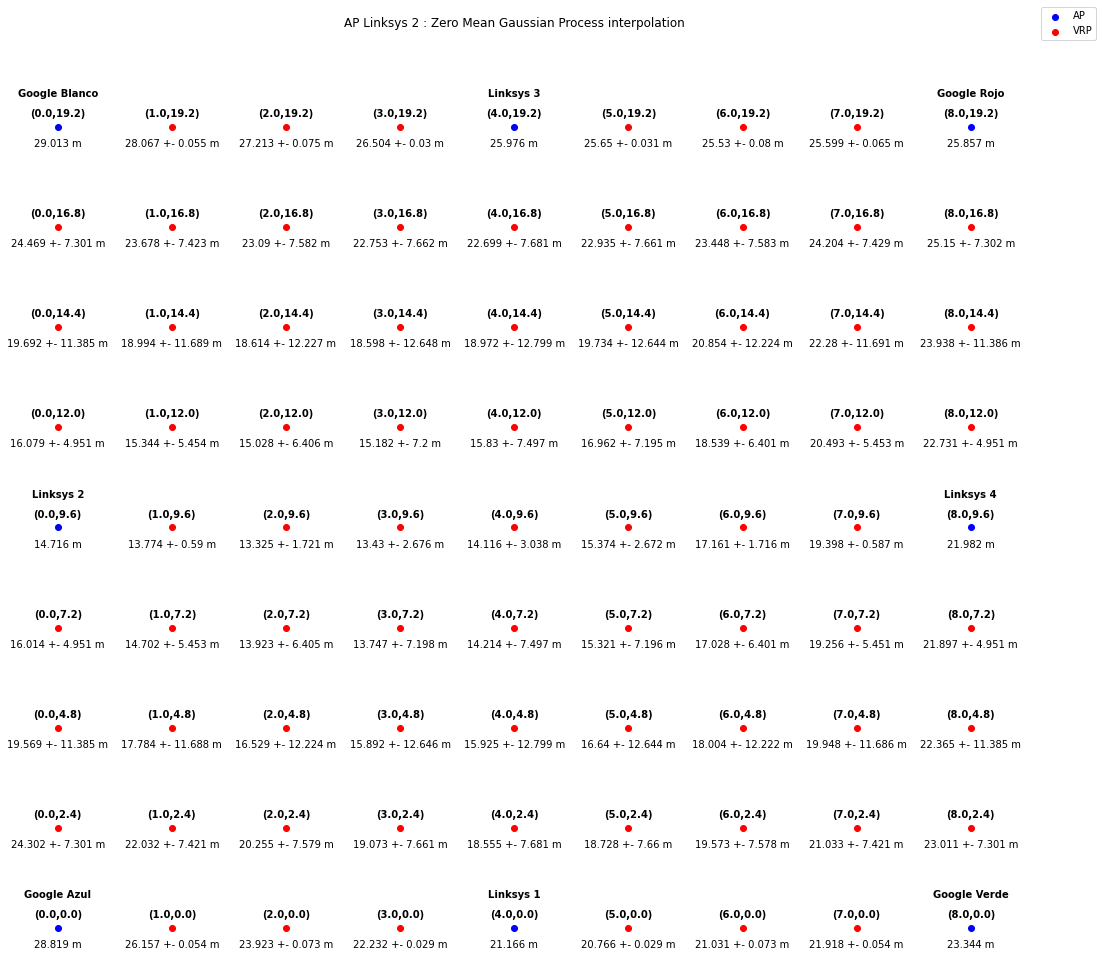

In [857]:
#@title ##Zero-Mean GPR
ap_selected = "Linksys 2"  #@param ['Google Blanco', 'Linksys 1', 'Google Azul', 'Linksys 2', 'Google Rojo', 'Linksys 3', 'Google Verde', 'Linksys 4']
sample = 1 #@param {type:"slider", min:0, max:100, step:1}

try:
  ap_indexes[ap_selected]
except:
  ap_selected = ap_labels[0]
  
"""
Zero Mean Gaussian Process interpolation:
    
    s_bar_star --> Mean estimated value for each VRP
    cov_s_star --> Posterior covariance matrix
    var_s_star --> VRP estimation variance
"""

plt.figure(figsize=(points_x*2, points_y*1.8))

plt.scatter(coordinates_ap[:,0], coordinates_ap[:,1], c='b')
plt.scatter(coordinates_vrp[:,0], coordinates_vrp[:,1], c='r')

plt.legend(labels=['AP','VRP'],loc="upper right",borderaxespad=-8)
plt.title('AP '+ap_selected+' : Zero Mean Gaussian Process interpolation',pad=60)
plt.axis('off')

for x,y,z in zip(coordinates_ap[:,0], coordinates_ap[:,1], ap_obs[:,int(ap_indexes[ap_selected]),sample]):
    label = f"{z.round(3)} m"

    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,-20), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center

for x in range(len(mean_array[int(ap_indexes[ap_selected]),sample])):
    label = f"{mean_array[int(ap_indexes[ap_selected]),sample][x,0].round(3)} +- {var_array[int(ap_indexes[ap_selected]),sample][x,0].round(3)} m"

    plt.annotate(label, # this is the text
                 (coordinates_vrp[x,0],coordinates_vrp[x,1]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,-20), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center

for x,y,z in zip(coordinates_ap[:,0],coordinates_ap[:,1], np.linspace(0, n_ap - 1, n_ap).astype(int)):

    label = f"{ap_labels[z]}"

    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,30), # distance from text to points (x,y)
                 ha='center', # horizontal alignment can be left, right or center
                 weight='bold')

for x,y,z in zip(coordinates[:,0],coordinates[:,1], np.linspace(0, n_points - 1, n_points).astype(int)):
    label = f"({locations[z,0]},{locations[z,1]})"

    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center',
                 weight='bold') # horizontal alignment can be left, right or center

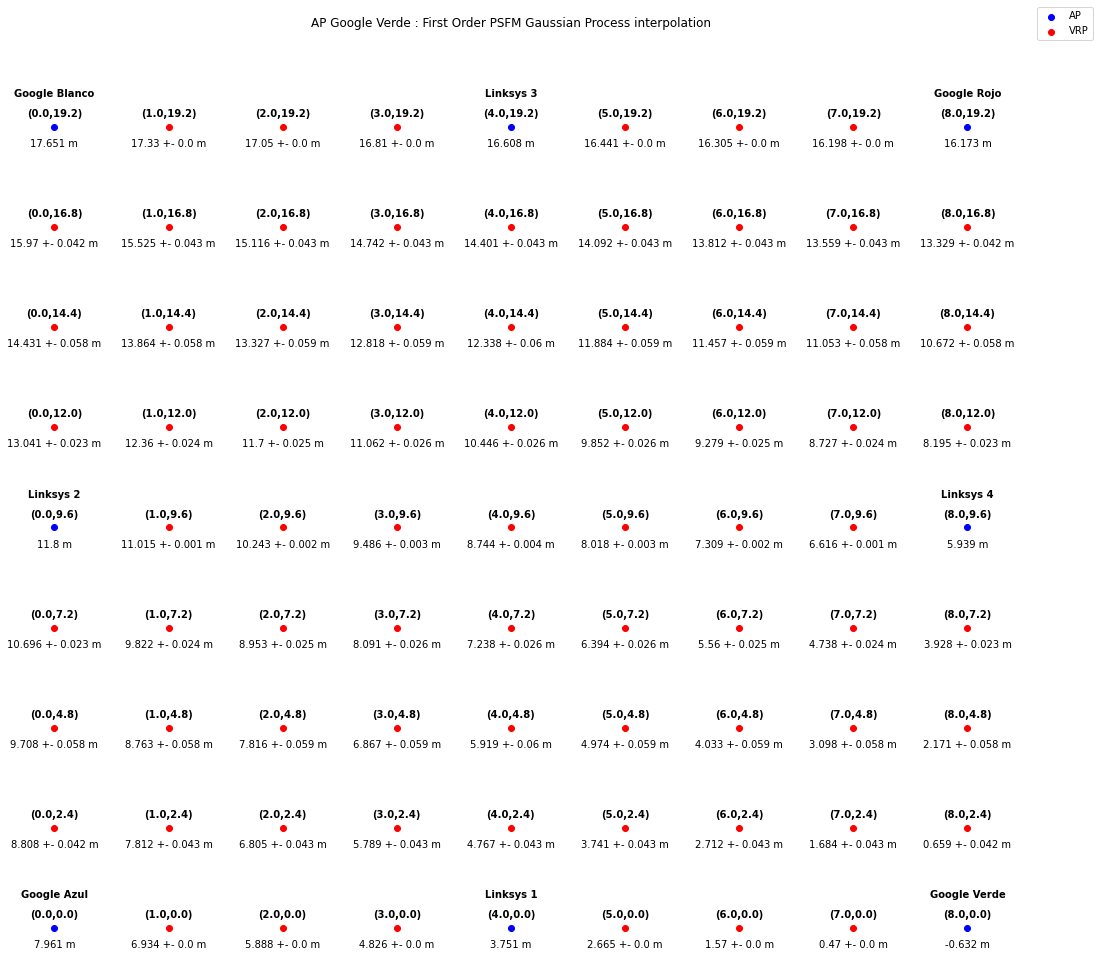

In [858]:
#@title ##First Order PSFM GPR
ap_selected = "Google Verde"  #@param ['Google Blanco', 'Linksys 1', 'Google Azul', 'Linksys 2', 'Google Rojo', 'Linksys 3', 'Google Verde']
sample = 8 #@param {type:"slider", min:0, max:100, step:1}

try:
  ap_indexes[ap_selected]
except:
  ap_selected = ap_labels[0]

"""
First Order PSFM Gaussian Process interpolation:
    
    s_bar_star --> Mean estimated value for each VRP
    cov_s_star --> Posterior covariance matrix
    var_s_star --> VRP estimation variance
"""

plt.figure(figsize=(points_x*2, points_y*1.8))

plt.scatter(coordinates_ap[:,0], coordinates_ap[:,1], c='b')
plt.scatter(coordinates_vrp[:,0], coordinates_vrp[:,1], c='r')

plt.legend(labels=['AP','VRP'],loc="upper right",borderaxespad=-8)
plt.title('AP '+ap_selected+' : First Order PSFM Gaussian Process interpolation',pad=60)
plt.axis('off')

for x,y,z in zip(coordinates_ap[:,0], coordinates_ap[:,1], ap_obs[:,int(ap_indexes[ap_selected]),sample]):
    label = f"{z.round(3)} m"

    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,-20), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center

for x in range(len(mean_array[int(ap_indexes[ap_selected]),sample])):
    label = f"{mean_psfm_array[int(ap_indexes[ap_selected]),sample][x,0].round(3)} +- {var_array[int(ap_indexes[ap_selected]),sample][x,0].round(3)} m"

    plt.annotate(label, # this is the text
                 (coordinates_vrp[x,0],coordinates_vrp[x,1]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,-20), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center

for x,y,z in zip(coordinates_ap[:,0],coordinates_ap[:,1], np.linspace(0, n_ap - 1, n_ap).astype(int)):

    label = f"{ap_labels[z]}"

    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,30), # distance from text to points (x,y)
                 ha='center', # horizontal alignment can be left, right or center
                 weight='bold')

for x,y,z in zip(coordinates[:,0],coordinates[:,1], np.linspace(0, n_points - 1, n_points).astype(int)):
    label = f"({locations[z,0]},{locations[z,1]})"

    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center',
                 weight='bold') # horizontal alignment can be left, right or center

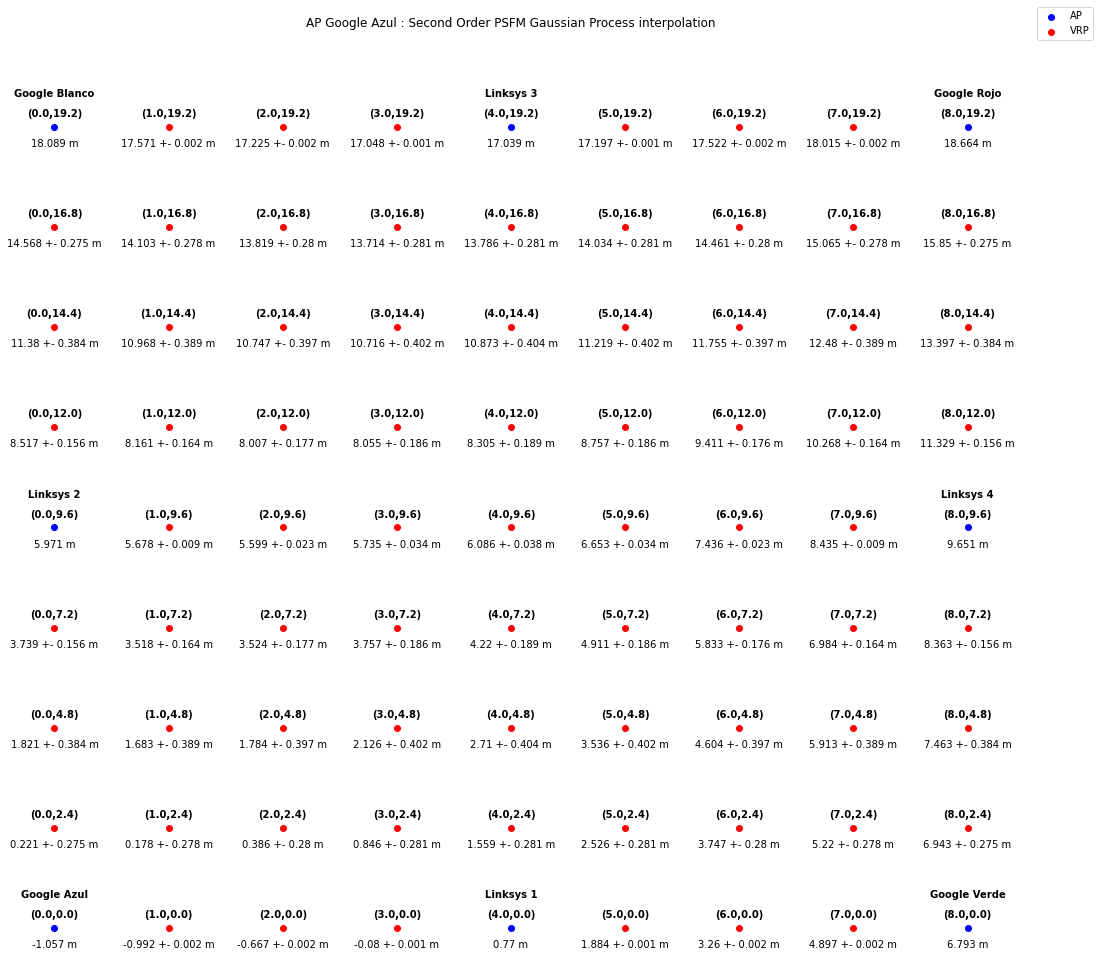

In [859]:
#@title ##Second Order PSFM GPR
ap_selected = "Google Azul"  #@param ['Google Blanco', 'Linksys 1', 'Google Azul', 'Linksys 2', 'Google Rojo', 'Linksys 3', 'Google Verde']
sample = 8 #@param {type:"slider", min:0, max:100, step:1}

try:
  ap_indexes[ap_selected]
except:
  ap_selected = ap_labels[0]

"""
Second Order PSFM Gaussian Process interpolation:
    
    s_bar_star --> Mean estimated value for each VRP
    cov_s_star --> Posterior covariance matrix
    var_s_star --> VRP estimation variance
"""

plt.figure(figsize=(points_x*2, points_y*1.8))

plt.scatter(coordinates_ap[:,0], coordinates_ap[:,1], c='b')
plt.scatter(coordinates_vrp[:,0], coordinates_vrp[:,1], c='r')

plt.legend(labels=['AP','VRP'],loc="upper right",borderaxespad=-8)
plt.title('AP '+ap_selected+' : Second Order PSFM Gaussian Process interpolation',pad=60)
plt.axis('off')

for x,y,z in zip(coordinates_ap[:,0], coordinates_ap[:,1], ap_obs[:,int(ap_indexes[ap_selected]),sample]):
    label = f"{z.round(3)} m"

    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,-20), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center

for x in range(len(mean_psfm2_array[int(ap_indexes[ap_selected]),sample])):
    label = f"{mean_psfm2_array[int(ap_indexes[ap_selected]),sample][x,0].round(3)} +- {var_array[int(ap_indexes[ap_selected]),sample][x,0].round(3)} m"

    plt.annotate(label, # this is the text
                 (coordinates_vrp[x,0],coordinates_vrp[x,1]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,-20), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center

for x,y,z in zip(coordinates_ap[:,0],coordinates_ap[:,1], np.linspace(0, n_ap - 1, n_ap).astype(int)):

    label = f"{ap_labels[z]}"

    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,30), # distance from text to points (x,y)
                 ha='center', # horizontal alignment can be left, right or center
                 weight='bold')

for x,y,z in zip(coordinates[:,0],coordinates[:,1], np.linspace(0, n_points - 1, n_points).astype(int)):
    label = f"({locations[z,0]},{locations[z,1]})"

    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center',
                 weight='bold') # horizontal alignment can be left, right or center

#Fingerprinting Database Construction

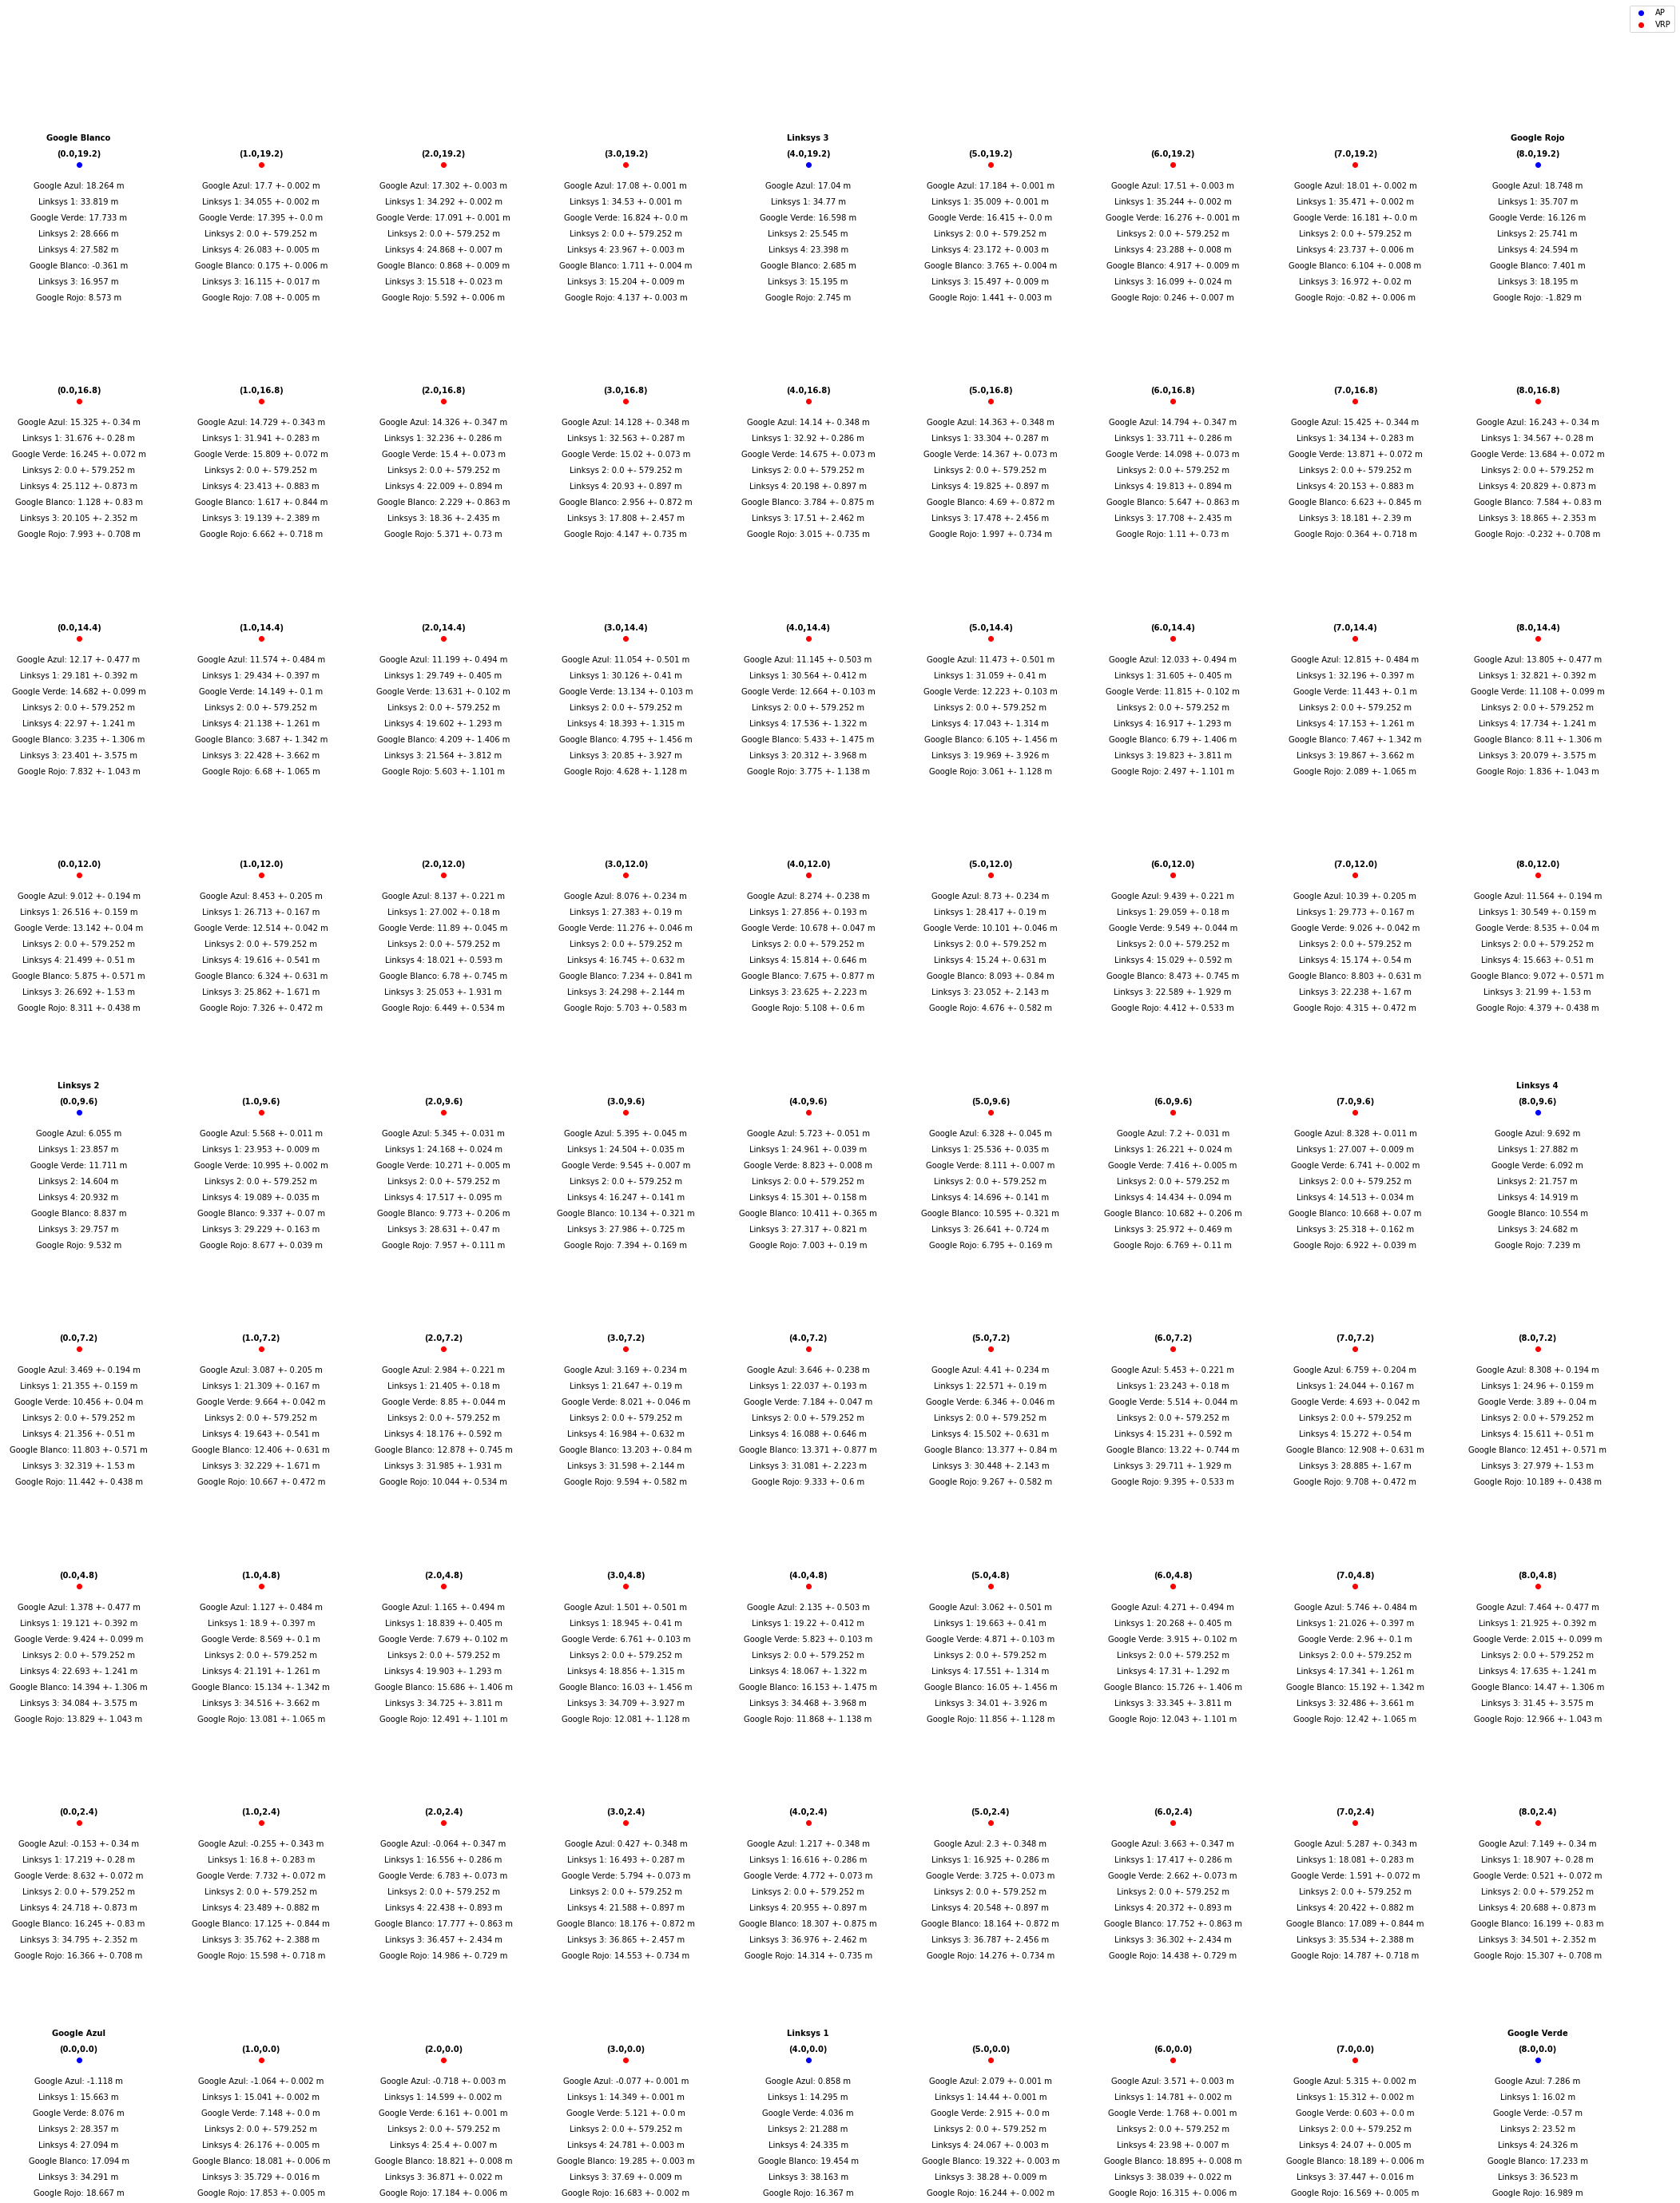

In [866]:
#@title ##Zero Mean GPR Fingerprinting Database plot
sample = 0 #@param {type:"slider", min:0, max:100, step:1}

plt.figure(figsize=(points_x*4, 6*n_ap))

plt.scatter(coordinates_ap[:,0], coordinates_ap[:,1], c='b')
plt.scatter(coordinates_vrp[:,0], coordinates_vrp[:,1], c='r')

plt.legend(labels=['AP','VRP'],loc="upper right",borderaxespad=-8)
plt.axis('off')

for x,y,z in zip(coordinates_ap[:,0],coordinates_ap[:,1], np.linspace(0, n_ap - 1, n_ap).astype(int)):

    label = f"{ap_labels[z]}"

    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,30), # distance from text to points (x,y)
                 ha='center', # horizontal alignment can be left, right or center
                 weight='bold')


for x,y,z in zip(coordinates[:,0],coordinates[:,1], np.linspace(0, n_points - 1, n_points).astype(int)):
    label = f"({locations[z,0]},{locations[z,1]})"

    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center',
                 weight='bold') # horizontal alignment can be left, right or center
                 
for x in range(ap_obs.shape[0]):
    for y in range(ap_obs.shape[0]):
        label = f"{ap_labels[y]}: {ap_obs[x,y,sample].round(3)} m"

        plt.annotate(label, # this is the text
                    (coordinates_ap[x,0],coordinates_ap[x,1]), # this is the point to label
                    textcoords="offset points", # how to position the text
                    xytext=(0,-30-y*20), # distance from text to points (x,y)
                    ha='center') # horizontal alignment can be left, right or center

for x in range(mean_array.shape[2]):
    for y in range(ap_obs.shape[0]):
        label = f"{ap_labels[y]}: {mean_array[y,sample,x,0].round(3)} +- {var_array[y,sample,x,0].round(3)} m"

        plt.annotate(label, # this is the text
                    (coordinates_vrp[x,0],coordinates_vrp[x,1]), # this is the point to label
                    textcoords="offset points", # how to position the text
                    xytext=(0,-30-y*20), # distance from text to points (x,y)
                    ha='center') # horizontal alignment can be left, right or center

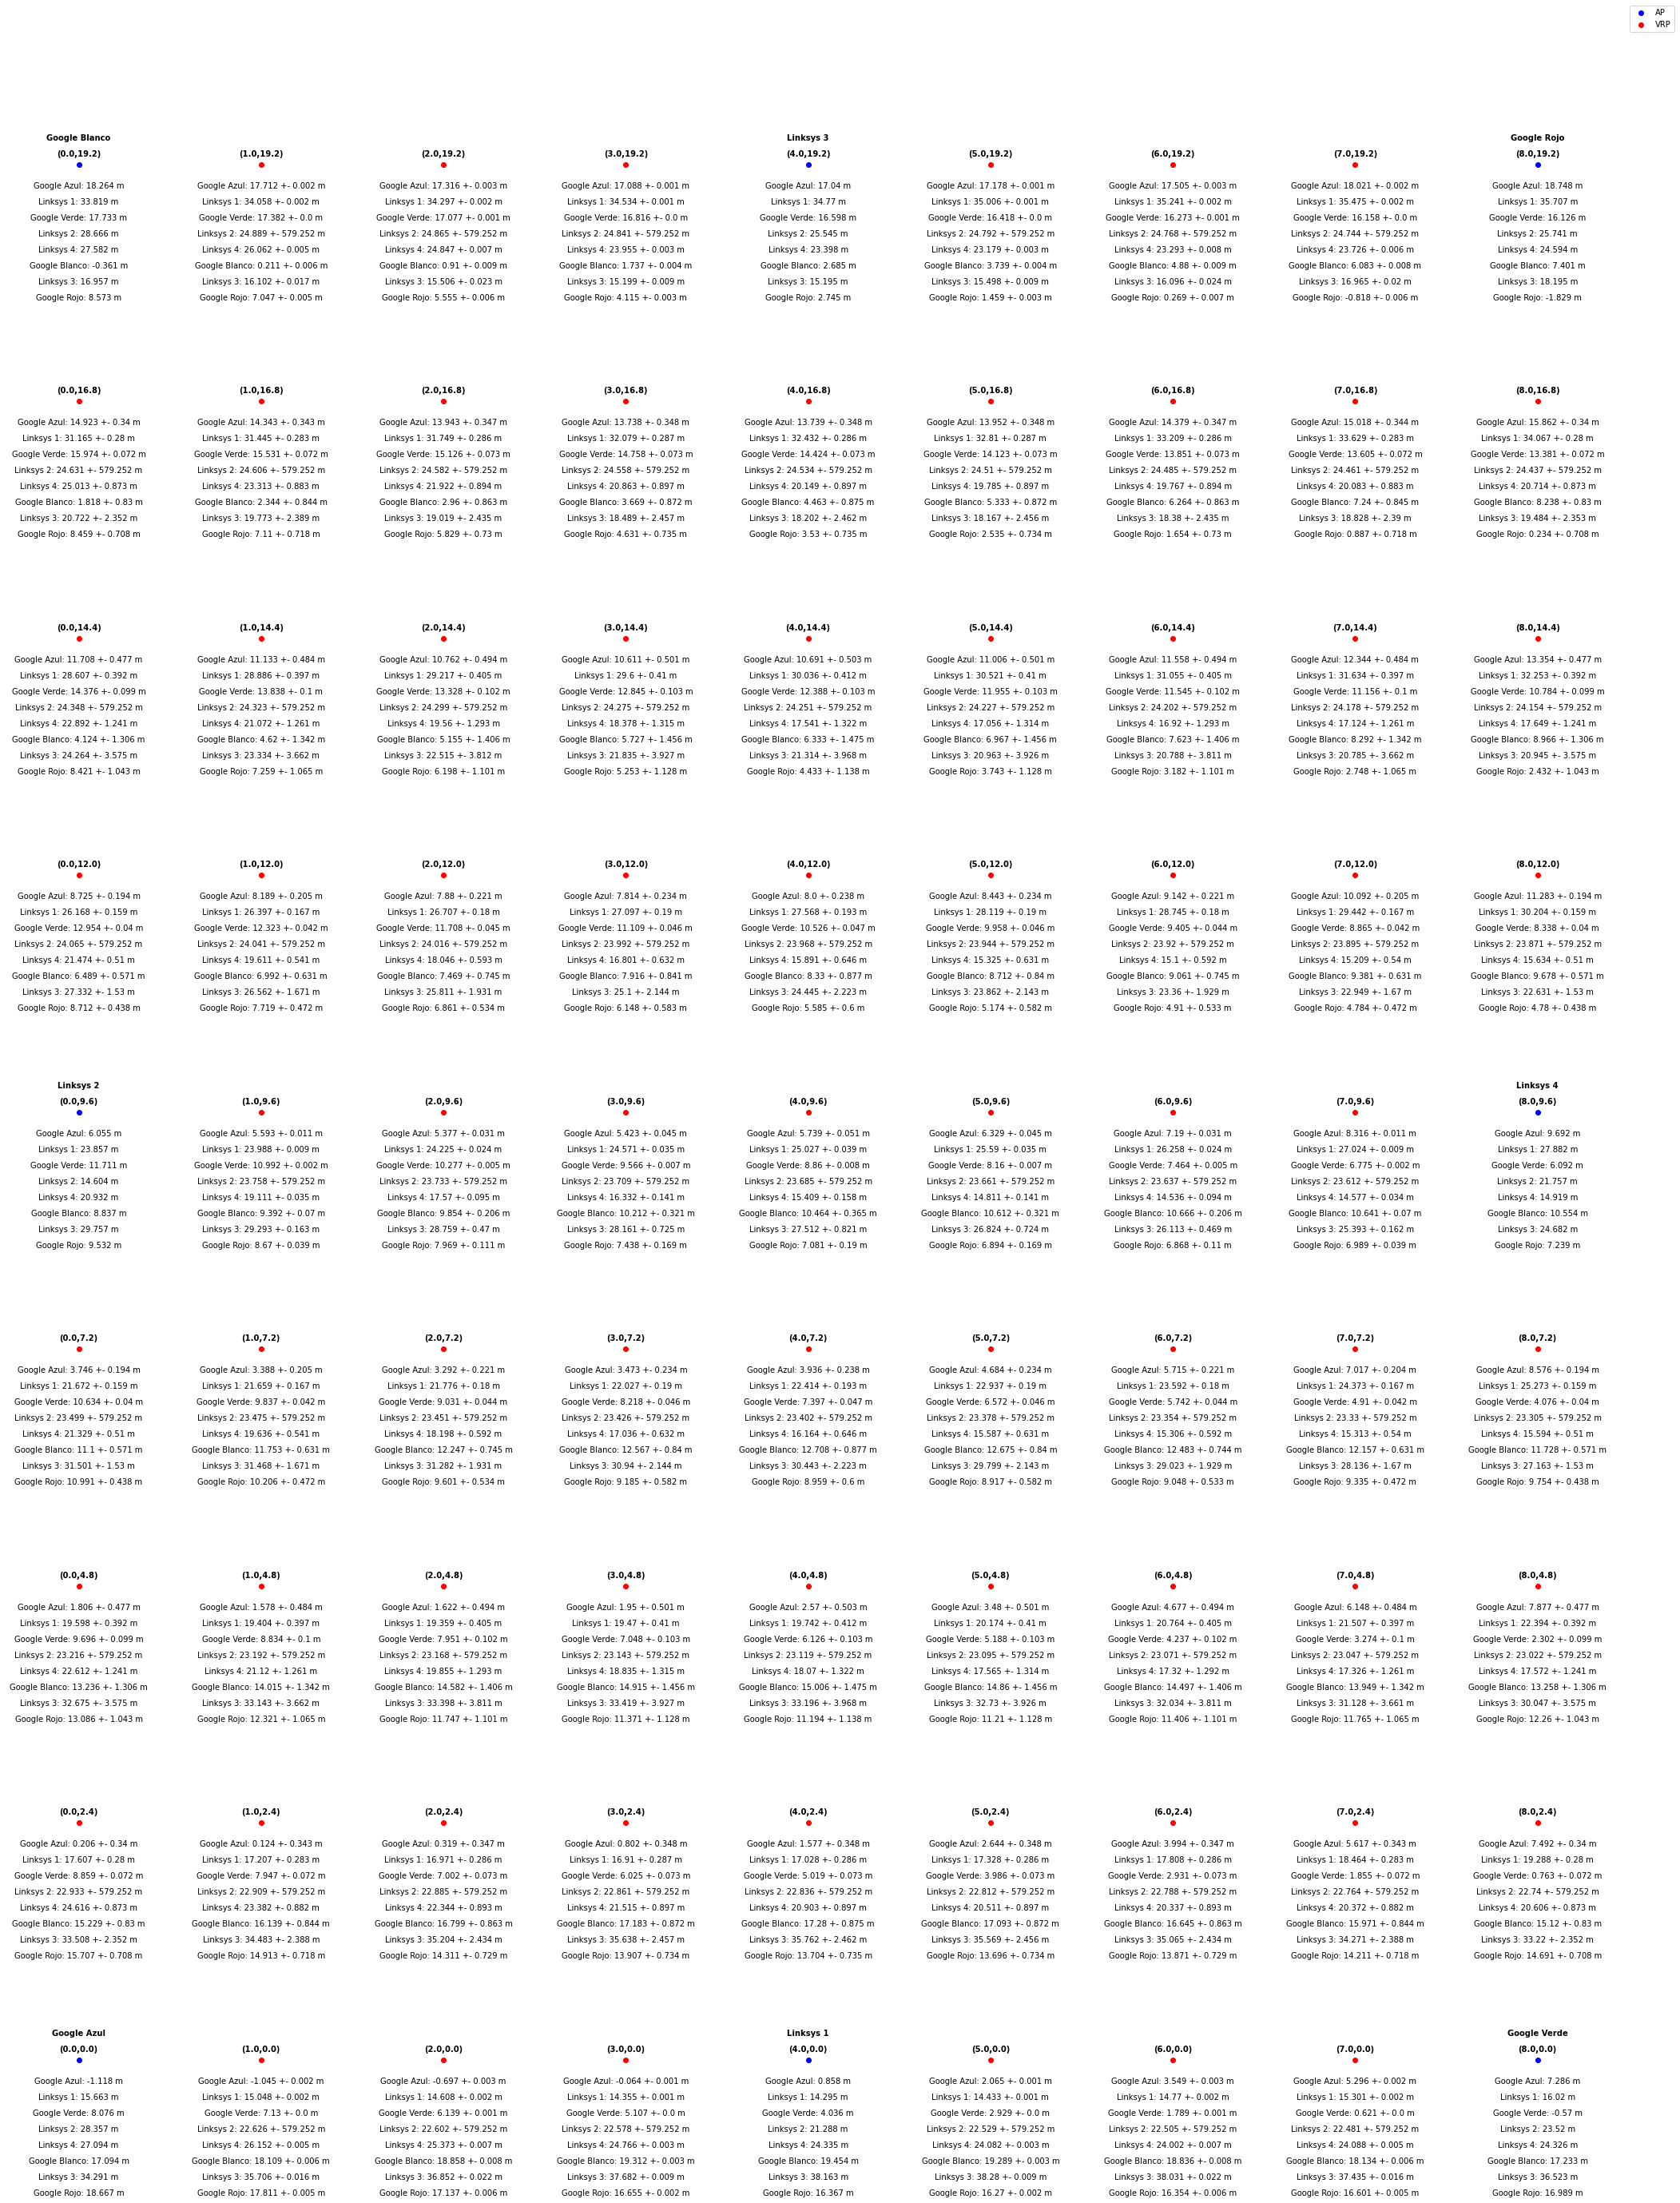

In [865]:
#@title ##First Order PSFM GPR Fingerprinting Database plot
sample = 0 #@param {type:"slider", min:0, max:100, step:1}

plt.figure(figsize=(points_x*4, 6*n_ap))

plt.scatter(coordinates_ap[:,0], coordinates_ap[:,1], c='b')
plt.scatter(coordinates_vrp[:,0], coordinates_vrp[:,1], c='r')

plt.legend(labels=['AP','VRP'],loc="upper right",borderaxespad=-8)
plt.axis('off')

for x,y,z in zip(coordinates_ap[:,0],coordinates_ap[:,1], np.linspace(0, n_ap - 1, n_ap).astype(int)):

    label = f"{ap_labels[z]}"

    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,30), # distance from text to points (x,y)
                 ha='center', # horizontal alignment can be left, right or center
                 weight='bold')


for x,y,z in zip(coordinates[:,0],coordinates[:,1], np.linspace(0, n_points - 1, n_points).astype(int)):
    label = f"({locations[z,0]},{locations[z,1]})"

    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center',
                 weight='bold') # horizontal alignment can be left, right or center
                 
for x in range(ap_obs.shape[0]):
    for y in range(ap_obs.shape[0]):
        label = f"{ap_labels[y]}: {ap_obs[x,y,sample].round(3)} m"

        plt.annotate(label, # this is the text
                    (coordinates_ap[x,0],coordinates_ap[x,1]), # this is the point to label
                    textcoords="offset points", # how to position the text
                    xytext=(0,-30-y*20), # distance from text to points (x,y)
                    ha='center') # horizontal alignment can be left, right or center

for x in range(mean_psfm_array.shape[2]):
    for y in range(ap_obs.shape[0]):
        label = f"{ap_labels[y]}: {mean_psfm_array[y,sample,x,0].round(3)} +- {var_array[y,sample,x,0].round(3)} m"

        plt.annotate(label, # this is the text
                    (coordinates_vrp[x,0],coordinates_vrp[x,1]), # this is the point to label
                    textcoords="offset points", # how to position the text
                    xytext=(0,-30-y*20), # distance from text to points (x,y)
                    ha='center') # horizontal alignment can be left, right or center

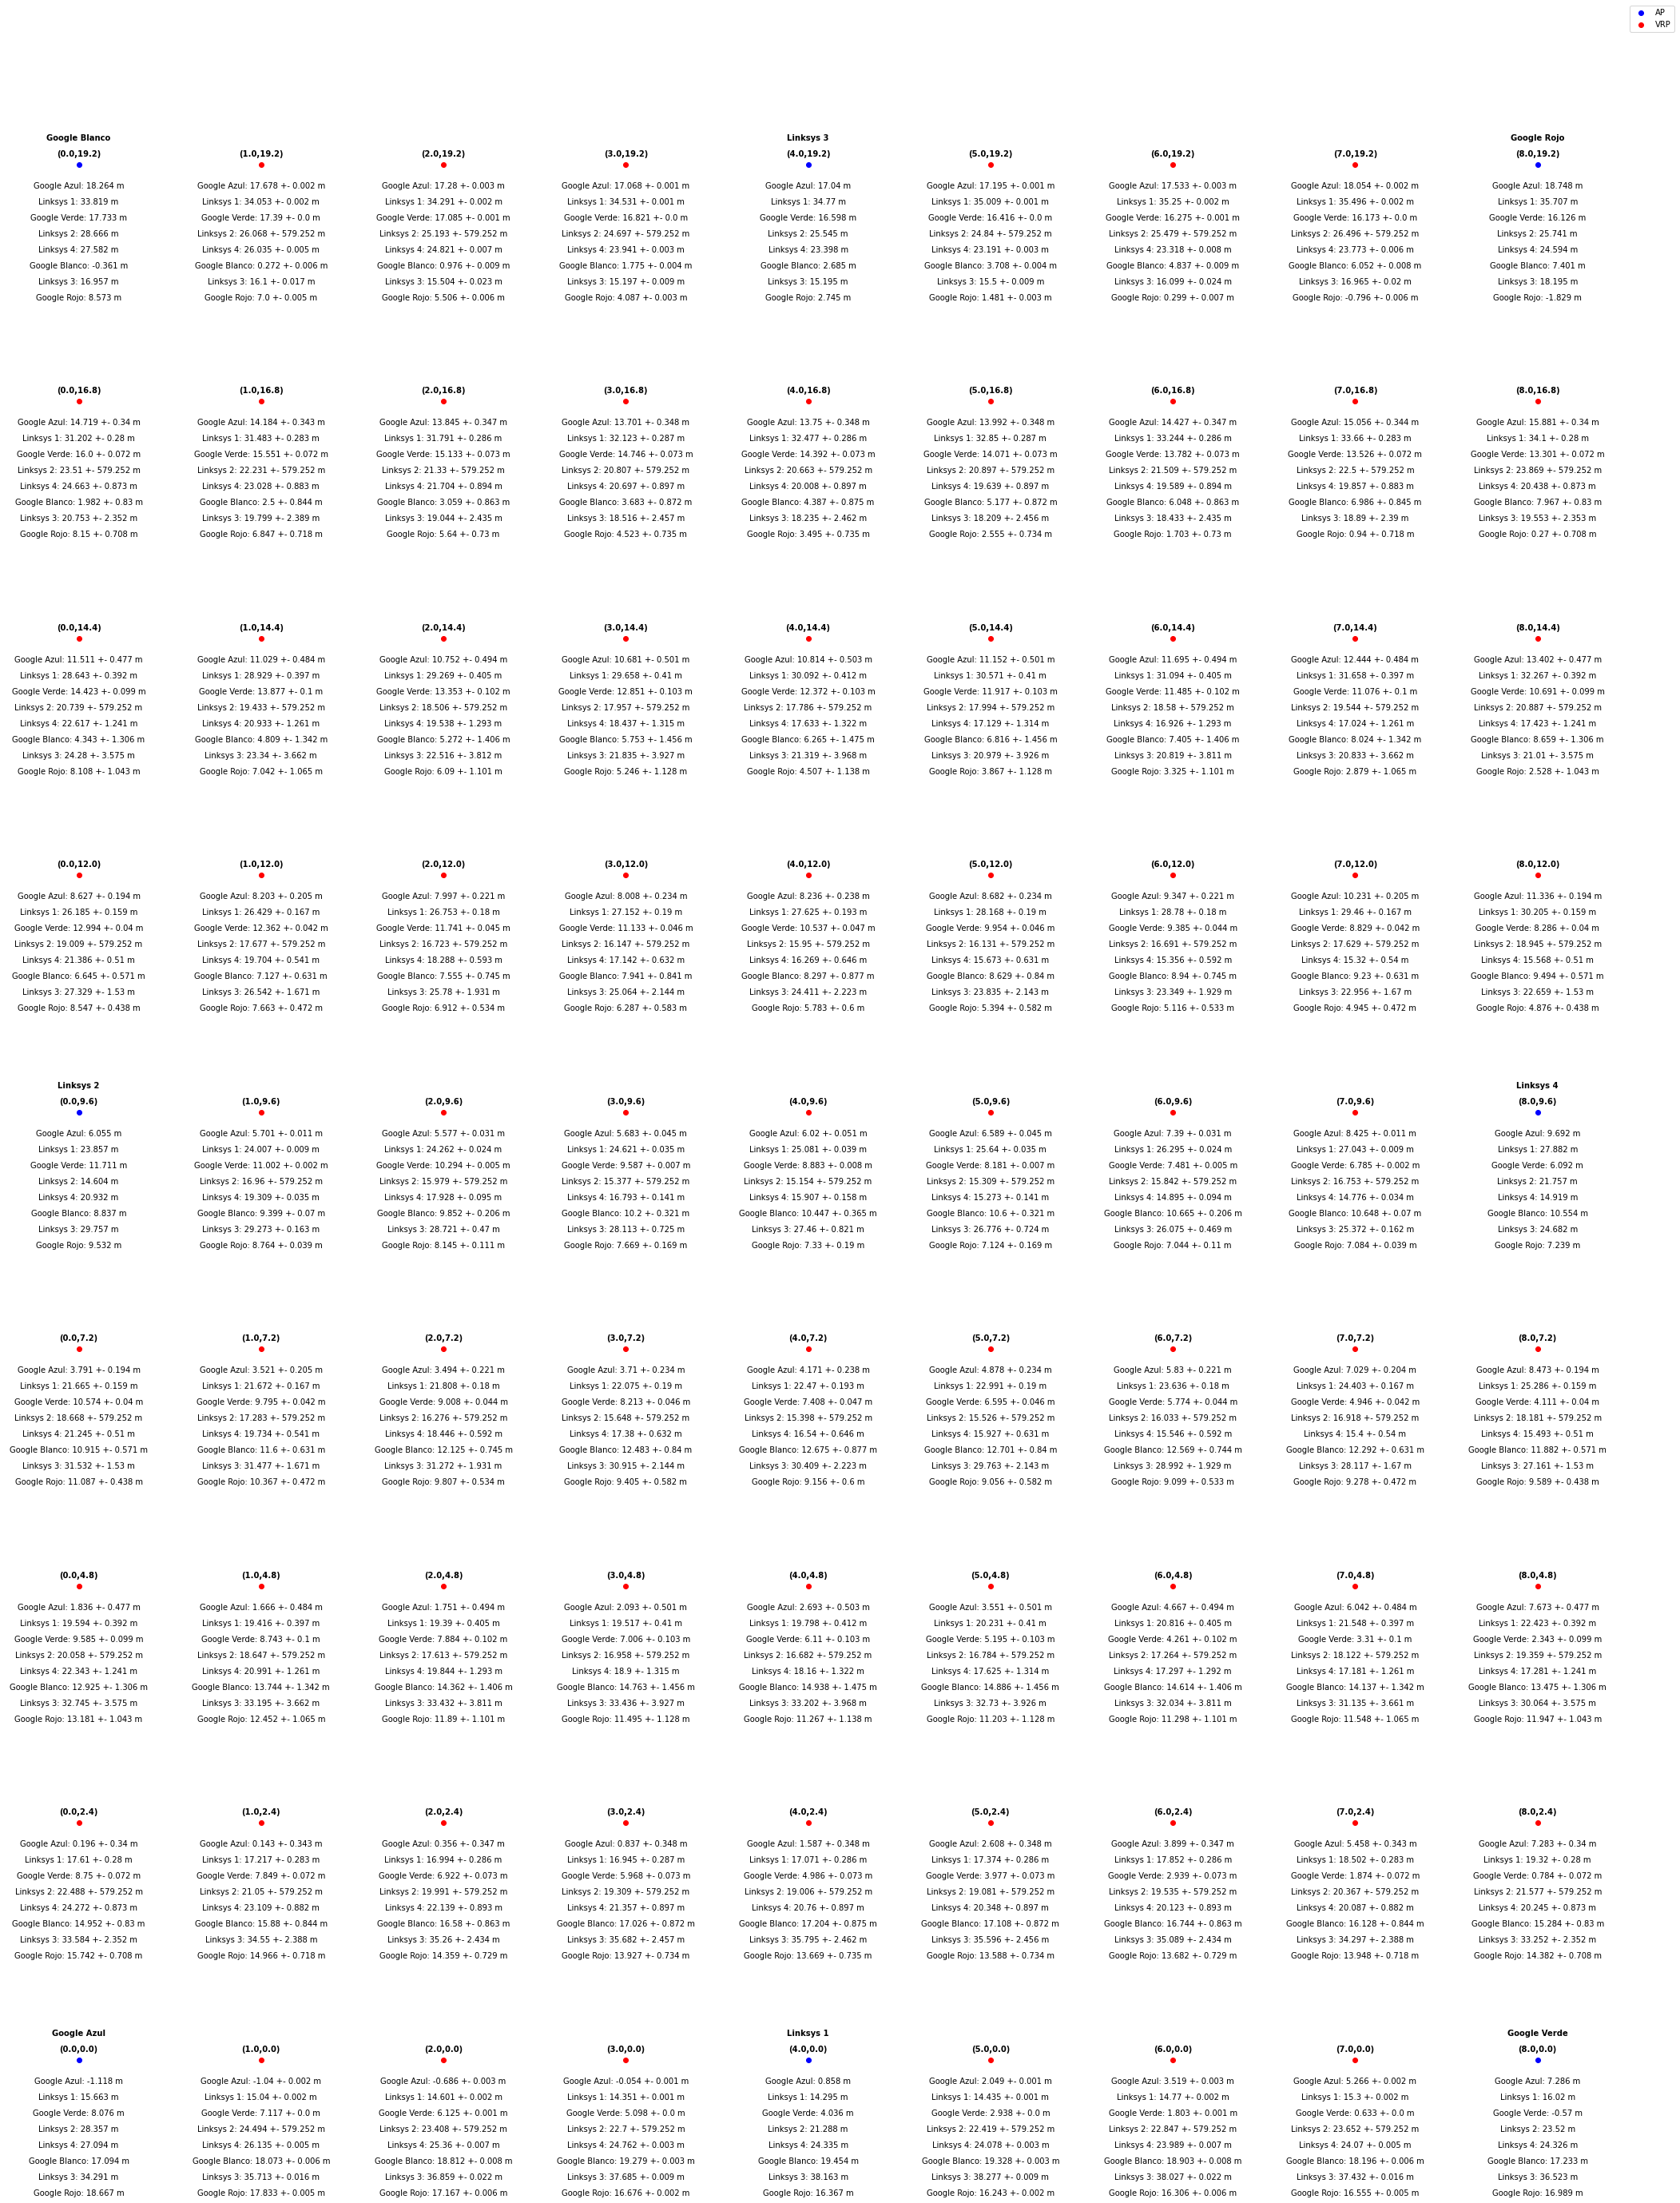

In [867]:
#@title ##Second Order PSFM GPR Fingerprinting Database plot
sample = 0 #@param {type:"slider", min:0, max:100, step:1}

plt.figure(figsize=(points_x*4, 6*n_ap))

plt.scatter(coordinates_ap[:,0], coordinates_ap[:,1], c='b')
plt.scatter(coordinates_vrp[:,0], coordinates_vrp[:,1], c='r')

plt.legend(labels=['AP','VRP'],loc="upper right",borderaxespad=-8)
plt.axis('off')

for x,y,z in zip(coordinates_ap[:,0],coordinates_ap[:,1], np.linspace(0, n_ap - 1, n_ap).astype(int)):

    label = f"{ap_labels[z]}"

    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,30), # distance from text to points (x,y)
                 ha='center', # horizontal alignment can be left, right or center
                 weight='bold')


for x,y,z in zip(coordinates[:,0],coordinates[:,1], np.linspace(0, n_points - 1, n_points).astype(int)):
    label = f"({locations[z,0]},{locations[z,1]})"

    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center',
                 weight='bold') # horizontal alignment can be left, right or center
                 
for x in range(ap_obs.shape[0]):
    for y in range(ap_obs.shape[0]):
        label = f"{ap_labels[y]}: {ap_obs[x,y,sample].round(3)} m"

        plt.annotate(label, # this is the text
                    (coordinates_ap[x,0],coordinates_ap[x,1]), # this is the point to label
                    textcoords="offset points", # how to position the text
                    xytext=(0,-30-y*20), # distance from text to points (x,y)
                    ha='center') # horizontal alignment can be left, right or center

for x in range(mean_psfm2_array.shape[2]):
    for y in range(ap_obs.shape[0]):
        label = f"{ap_labels[y]}: {mean_psfm2_array[y,sample,x,0].round(3)} +- {var_array[y,sample,x,0].round(3)} m"

        plt.annotate(label, # this is the text
                    (coordinates_vrp[x,0],coordinates_vrp[x,1]), # this is the point to label
                    textcoords="offset points", # how to position the text
                    xytext=(0,-30-y*20), # distance from text to points (x,y)
                    ha='center') # horizontal alignment can be left, right or center